In [1]:
import argparse
import os
import random
import time
from distutils.util import strtobool
import highway_env
import gymnasium as gym
import numpy as np
#import pybullet_envs  # noqa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from stable_baselines3.common.buffers import GraphReplayBuffer
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.nn import GATv2Conv
from graph_generator import create_whole_ego_bigraph_tensor_dynamic
#import traceback
from torch_geometric.data import Batch

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)
from utils_gnn import load_model
#import pygame
import torch.multiprocessing as mp
from torch.profiler import profiler, ProfilerActivity
import os 
from IPython import display as ipythondisplay
from gymnasium.wrappers import RecordVideo
from pathlib import Path
import base64
from tqdm import trange




def parse_args():
    
    # fmt: off
    parser = argparse.ArgumentParser()
    # parser.add_argument("--exp-name", type=str, default=os.path.basename(__file__).rstrip(".py"),
    #     help="the name of this experiment")
    parser.add_argument("--seed", type=int, default=42,
        help="seed of the experiment")
    parser.add_argument("--torch-deterministic", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="if toggled, `torch.backends.cudnn.deterministic=False`")
    parser.add_argument("--cuda", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="if toggled, cuda will be enabled by default")
    # parser.add_argument("--track", type=lambda x: bool(strtobool(x)), default=False, nargs="?", const=True,
    #     help="if toggled, this experiment will be tracked with Weights and Biases")
    # parser.add_argument("--wandb-project-name", type=str, default="SAC_GNN",
    #     help="the wandb's project name")
    # parser.add_argument("--wandb-entity", type=str, default=None,
    #     help="the entity (team) of wandb's project")
    # parser.add_argument("--capture-video", type=lambda x: bool(strtobool(x)), default=False, nargs="?", const=True,
    #     help="whether to capture videos of the agent performances (check out `videos` folder)")

    # Algorithm specific arguments
    parser.add_argument("--env-id", type=str, default="highway-v0",
        help="the id of the environment")
    parser.add_argument("--total-timesteps", type=int, default=1000001,
        help="total timesteps of the experiments")
    parser.add_argument("--buffer-size", type=int, default=int(1e6),
        help="the replay memory buffer size")#1e6
    parser.add_argument("--gamma", type=float, default=0.99,
        help="the discount factor gamma")
    parser.add_argument("--tau", type=float, default=0.005,
        help="target smoothing coefficient (default: 0.005)")
    parser.add_argument("--batch-size", type=int, default=256,
        help="the batch size of sample from the reply memory")
    parser.add_argument("--learning-starts", type=int, default= 100,
        help="timestep to start learning")#5e3,15000
    parser.add_argument("--policy-lr", type=float, default=3e-4,
        help="the learning rate of the policy network optimizer")
    parser.add_argument("--q-lr", type=float, default=3e-4,
        help="the learning rate of the Q network network optimizer")#1e-3
    parser.add_argument("--policy-frequency", type=int, default=15,
        help="the frequency of training policy (delayed)")
    parser.add_argument("--target-network-frequency", type=int, default=1, # Denis Yarats' implementation delays this by 2.
        help="the frequency of updates for the target nerworks") #train frequency in sb3 IT IS 1
    parser.add_argument("--noise-clip", type=float, default=0.5,
        help="noise clip parameter of the Target Policy Smoothing Regularization")
    parser.add_argument("--alpha", type=float, default=0.5,
            help="Entropy regularization coefficient.")
    parser.add_argument("--autotune", type=lambda x:bool(strtobool(x)), default=True, nargs="?", const=True,
        help="automatic tuning of the entropy coefficient")
    parser.add_argument("--dropout",type=float,default=0.5,
        help="dropout for the GNN layers")
    parser.add_argument("--vehicles-count",type=int,default=25,
        help="number of vehicles")
    
    # rewards
    # parser.add_argument("--high-speed-reward",type=float,default=0.7,
    #     help="reward for high speed")
    # parser.add_argument("--on-road-reward",type=float,default=0.2,
    #     help=" on road reward")
    # parser.add_argument("--collision-reward",type=float,default=-1,
    #     help="penalty for collisons")
    # parser.add_argument("--lane-change-reward",type=float,default=0.1,
    #     help="rewarding while changing lanes")
    # parser.add_argument("--right-lane-reward",type=float,default=0.1,
    #     help="reward for driving in the right lane. useful for exit ramp scenario")
    
    args = parser.parse_args()
    # fmt: on
    return args


def make_env(env_id, seed):
    #def thunk():
    env = gym.make(env_id)
    env.configure({
     
    #"import_module": "highway_env",
    "observation" : { "type" : "Kinematics",
                     "vehicles_count" :25,
                     "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h","heading","long_off","lat_off","ang_off"],
                    # "features_range": {
                    #     "x": [-100, 100],
                    #     "y": [-100, 100],
                    #     "vx": [-20, 25],
                    #     "vy": [-20, 25]  },
                    "absolute" : True,
                    "order" : "sorted",
                    "on_road" :  True,
                     "normalize" : True,
                       
        },
    "action": {
        "type": "ContinuousAction",
        "acceleration_range" : [-3.5,3.5],
        "steering_range" : [-np.pi/18,np.pi/18],
        'lateral' : True,
        'longitudinal': True,
        "speed_range" : [20,25],    
        
    }, #'offscreen_rendering': True,
        'offroad_terminal': True,
        "normalize_reward" : True,
        "simulation_frequency": 15,
        'high_speed_reward': 0.5,
        'on_road_reward' : 0.1,
        'collision_reward': -1,
        #'right_lane_reward' : 0.1,
        #"high_speed_reward": 0.4,  # The reward received when driving at full speed, linearly mapped to zero for
                                       # lower speeds according to config["reward_speed_range"].
        "lane_change_reward": 0.1,
        'reward_speed_range': [20, 25],
        'vehicles_density' : 1,
        
        "centering_position": [0.3, 0.5],
   
        'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
  
        'scaling': 5.5,
 
        'duration' : 200,
        "policy_frequency": 15
    })

   
        #env.reset()

    #env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    env.reset(seed=seed)
    return env

    #return thunk



#the input should be the Data object generated from the obsevation 
#nodes - vehicles , node attributes-  kinematic features
#node attributes - (#nodes,node attributes) , adjacency matrix -(#nodes,#nodes) , edge attributes -(# edges, #edge attributes)

class SoftGATv2Network(nn.Module):
    """ The SoftGATv2Network class is a neural network model that uses graph attention networks to process
     input data and output a new embedding for the ego vehicle node.
    """
    
    def __init__(self,env,graph_data,device,num_heads=5,dropout=0.8):
        super(SoftGATv2Network,self).__init__()
        self.device = device
        #graph_data = graph_data.to(self.device)
        self.num_heads = num_heads
        self.input_dim = graph_data.num_node_features
        #num_actions = np.prod(env.action_space.shape)
        edge_dim = graph_data.edge_attr.shape[1]
        #output_dim = graph_data.x.shape
        output_dim_row = graph_data.num_nodes
        #output_dim_column = graph_data.num_node_features
        self.output_dim_column = np.array(env.observation_space.shape).prod()
        self.dropout = dropout
        #self.input_dim = np.array(env.observation_space.shape).prod() + np.prod(env.action_space.shape)
        self.conv1 = GATv2Conv(in_channels= self.input_dim, out_channels= num_heads*self.input_dim,heads=num_heads,dropout=self.dropout,edge_dim=edge_dim,add_self_loops= False)
        
        self.conv2 = GATv2Conv(in_channels= -1 ,out_channels=2*num_heads*self.input_dim,heads=1,dropout=self.dropout,edge_dim=edge_dim,add_self_loops=False)
        
        #self.conv3 = GATv2Conv(in_channels= -1,out_channels= 4*num_heads*self.input_dim,heads=1,dropout=self.dropout,edge_dim=edge_dim,add_self_loops=False)
        
        self.dense = nn.Sequential(nn.Linear(2*num_heads*self.input_dim,output_dim_row),nn.Dropout(dropout),
                                   nn.Linear(output_dim_row,self.output_dim_column))
        
        
        
    
       #handle bothe Batch of Graphs and single graph inputs 
    def forward(self,graph_data):
        
        
        if isinstance(graph_data,Batch):
            x ,edge_index,edge_attr,batch = graph_data.x , graph_data.edge_index, graph_data.edge_attr, graph_data.batch
            #graph_batch_size = args.batch_size
        else:
            x ,edge_index,edge_attr = graph_data.x , graph_data.edge_index, graph_data.edge_attr
                                                                                                                                    
                                                                                                                                    
        
        x = F.relu(self.conv1(x,edge_index,edge_attr=edge_attr))
        x = F.dropout(x,p=self.dropout,training=self.training)
        
        x = F.relu(self.conv2(x,edge_index,edge_attr=edge_attr))
        x = F.dropout(x,p=self.dropout,training=self.training)
        
        # x = F.relu(self.conv3(x,edge_index,edge_attr=edge_attr))
        # x = F.dropout(x,p=self.dropout,training=self.training)

        #get the ego embeddings from the network
        if isinstance(graph_data,Batch):
            #new_ego_node_embeddings = torch.zeros((graph_data.num_graphs,4*self.num_heads*self.input_dim),device=self.device) # Shape: (batch_size, embedding_size)
            new_ego_node_embeddings = []
            for graph_index in torch.unique(batch):
                graph_mask = (batch == graph_index)
                new_ego_embed = x[graph_mask][0]
                new_ego_node_embeddings.append(new_ego_embed)
            new_ego_node_embeddings = torch.stack(new_ego_node_embeddings,dim=0)
        # for a single graph input while training
        else:
            new_ego_node_embeddings = x[0]

        #pass the ego embeddings to a dense layer
        new_ego_node_embeddings = torch.sigmoid(self.dense(new_ego_node_embeddings))
       
        return new_ego_node_embeddings
        
        
        
        
# ALGO LOGIC: initialize agent here: 
# the critic networks - Q1 and Q2 
class SoftQNetwork_GNN(nn.Module):
    def __init__(self, env,graph_data,device):
        super().__init__()
        self.device = device
        self.gat_gnn_critic = SoftGATv2Network(env,graph_data,self.device).to(self.device)
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod() + np.prod(env.action_space.shape), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)
        

    def forward(self, x, a):
        x = self.gat_gnn_critic(x)
        x = torch.cat([x, a], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


LOG_STD_MAX = 2
LOG_STD_MIN = -5


class Actor_GNN(nn.Module):
    def __init__(self, env,graph_data,device):
        super().__init__()
        self.device = device
        self.gat_gnn_actor = SoftGATv2Network(env,graph_data,self.device).to(self.device)
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(env.action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.action_space.shape))
        # action rescaling --maybe not needed, the acceleration is less, so the ego vehicle is slow.
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )
        

    def forward(self, x):
        x = self.gat_gnn_actor(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (log_std + 1)  # From SpinUp / Denis Yarats

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        if log_prob.dim() ==1:
            log_prob = log_prob.unsqueeze(1)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean







def record_videos(env, video_folder="/Users/haridevaraj/Documents/VOLVO/Models/GNN"):
    wrapped = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True)

    # Capture intermediate frames
    env.unwrapped.set_record_video_wrapper(wrapped)

    return wrapped


def show_videos(path="videos"):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))


# #os.environ['SDL_VIDEODRIVER'] = 'dummy'
# #uncommnet below two line to view the vido while training
# os.system("Xvfb :1 -screen 0 1024x768x24 &")
# os.environ['DISPLAY'] = ':1'


   

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available()else "cpu")




seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
args = parse_args()
exp_name = "dddd"
device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

envs = make_env("highway-v0", seed)
     # TRY NOT TO MODIFY: start the game
     # TRY NOT TO MODIFY: start the game
obs,info = envs.reset(seed=seed)
plt.imshow(envs)
plt.imshow()

usage: ipykernel_launcher.py [-h] [--seed SEED]
                             [--torch-deterministic [TORCH_DETERMINISTIC]]
                             [--cuda [CUDA]] [--env-id ENV_ID]
                             [--total-timesteps TOTAL_TIMESTEPS]
                             [--buffer-size BUFFER_SIZE] [--gamma GAMMA]
                             [--tau TAU] [--batch-size BATCH_SIZE]
                             [--learning-starts LEARNING_STARTS]
                             [--policy-lr POLICY_LR] [--q-lr Q_LR]
                             [--policy-frequency POLICY_FREQUENCY]
                             [--target-network-frequency TARGET_NETWORK_FREQUENCY]
                             [--noise-clip NOISE_CLIP] [--alpha ALPHA]
                             [--autotune [AUTOTUNE]] [--dropout DROPOUT]
                             [--vehicles-count VEHICLES_COUNT]
ipykernel_launcher.py: error: unrecognized arguments: --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.sig

SystemExit: 2

/Users/haridevaraj/opt/anaconda3/envs/volvo/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3405: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


/Users/haridevaraj/opt/anaconda3/envs/volvo/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


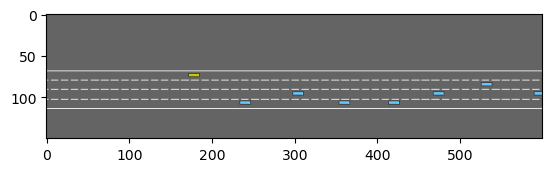

In [22]:
import gymnasium as gym

def make_env(env_id, seed):
    #def thunk():
    env = gym.make(env_id)
    env.configure({
     
    #"import_module": "highway_env",
    "observation" : { "type" : "Kinematics",
                     "vehicles_count" :25,
                     "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h","heading","long_off","lat_off","ang_off"],
                    # "features_range": {
                    #     "x": [-100, 100],
                    #     "y": [-100, 100],
                    #     "vx": [-20, 25],
                    #     "vy": [-20, 25]  },
                    "absolute" : True,
                    "order" : "sorted",
                    "on_road" :  True,
                     "normalize" : True,
                       
        },
    "action": {
        "type": "ContinuousAction",
        "acceleration_range" : [-3.5,3.5],
        "steering_range" : [-np.pi/18,np.pi/18],
        'lateral' : True,
        'longitudinal': True,
        "speed_range" : [20,25],    
        
    }, #'offscreen_rendering': True,
        'offroad_terminal': True,
        "normalize_reward" : True,
        "simulation_frequency": 15,
        'high_speed_reward': 0.5,
        'on_road_reward' : 0.1,
        'collision_reward': -1,
        #'right_lane_reward' : 0.1,
        #"high_speed_reward": 0.4,  # The reward received when driving at full speed, linearly mapped to zero for
                                       # lower speeds according to config["reward_speed_range"].
        "lane_change_reward": 0.1,
        'reward_speed_range': [20, 25],
        'vehicles_density' : 1,
        
        "centering_position": [0.3, 0.5],
   
        'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
  
        'scaling': 2.8,
 
        'duration' : 200,
        "policy_frequency": 15
    })

   
        #env.reset()

    #env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    env.reset(seed=seed)
    return env

    #return thunk
#env = gym.make('highway-v0', render_mode='rgb_array')
#env.reset()
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
envs = make_env("highway-v0", seed)
     # TRY NOT TO MODIFY: start the game
     # TRY NOT TO MODIFY: start the game
obs,info = envs.reset(seed=seed)
rendered_image = envs.render()
plt.imshow(rendered_image)
#plt.xticks(range(0, rendered_image.shape[1], 1000))
plt.show()

In [12]:
#args = parse_args()
device = torch.device("cuda" if torch.cuda.is_available()else "cpu")

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
args = parse_args()
# exp_name = "dddd"
# device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

envs = make_env(args.env_id, args.seed)
     # TRY NOT TO MODIFY: start the game
     # TRY NOT TO MODIFY: start the game
obs,info = envs.reset(seed=seed)
    #print(info)
 
    #print("obs1",obs)
    #print()
   

    
ego_graph_data = create_whole_ego_bigraph_tensor_dynamic(obs)
    
    
actor = Actor_GNN(envs,ego_graph_data,device)
actor_eval = load_model(model_path="SAC_GNN_final_kinda/sac_gnn_2_öow/sac_gnn_expl20231007-102109.pt",actor_network=actor)

usage: ipykernel_launcher.py [-h] [--seed SEED]
                             [--torch-deterministic [TORCH_DETERMINISTIC]]
                             [--cuda [CUDA]] [--env-id ENV_ID]
                             [--total-timesteps TOTAL_TIMESTEPS]
                             [--buffer-size BUFFER_SIZE] [--gamma GAMMA]
                             [--tau TAU] [--batch-size BATCH_SIZE]
                             [--learning-starts LEARNING_STARTS]
                             [--policy-lr POLICY_LR] [--q-lr Q_LR]
                             [--policy-frequency POLICY_FREQUENCY]
                             [--target-network-frequency TARGET_NETWORK_FREQUENCY]
                             [--noise-clip NOISE_CLIP] [--alpha ALPHA]
                             [--autotune [AUTOTUNE]] [--dropout DROPOUT]
                             [--vehicles-count VEHICLES_COUNT]
ipykernel_launcher.py: error: unrecognized arguments: --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.sig

SystemExit: 2

/Users/haridevaraj/opt/anaconda3/envs/volvo/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3405: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
att_1= (actor_eval.gat_gnn_actor.conv1.att[0]).detach().cpu().numpy()
att_2= (actor_eval.gat_gnn_actor.conv2.att[0]).detach().cpu().numpy()